In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]
import seaborn as sns
from scipy import stats
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#Define IAM Role
import boto3
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.predictor import Predictor
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.tuner import HyperparameterTuner, IntegerParameter

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
# Set SageMaker and S3 client variables
sess = sagemaker.Session()

s3_region =  'us-east-1'
s3_client = boto3.client("s3", region_name=s3_region)
sm_boto3 = boto3.client("sagemaker")

sagemaker_role = sagemaker.get_execution_role()

bucket_name = 'bucket--ganesh'
read_prefix = 'Project/RF-try/Data'

input_file = f"{read_prefix}/advertising.csv"
testing_file = f"{read_prefix}/test.csv"
training_file = f"{read_prefix}/train.csv"
s3_model_key = f"RF/model/rf_model.joblib"


input_file_loc = f"s3://{bucket_name}/{input_file}" 
train_file_loc = f"s3://{bucket_name}/{training_file}" 
test_file_loc = f"s3://{bucket_name}/{testing_file}" 
s3_model_path = f"s3://{bucket_name}/{s3_model_key}" 

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# Load the data.
data = pd.read_csv(input_file_loc)
data

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
...,...,...,...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,2016-02-11 21:49:00,1
996,51.30,45,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,2016-04-22 02:07:01,1
997,51.63,51,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,2016-02-01 17:24:57,1
998,55.55,19,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,2016-03-24 02:35:54,0


In [4]:
# Timestamp conversion to seconds
data['Timestamp'] = (pd.to_datetime(data['Timestamp']) - pd.to_datetime(data['Timestamp'][0])).dt.total_seconds()

# Drop non-integer columns
data = data.drop(columns=['Ad Topic Line', 'Country', 'City'])

# Extract features and target variable
X = data.iloc[:, 1:-1].values.astype('float64')
y = data['Clicked on Ad'].values

# Pre-processing - normalization of data
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Classification report for 25% of data using Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       136
           1       0.88      0.96      0.92       114

    accuracy                           0.92       250
   macro avg       0.92      0.93      0.92       250
weighted avg       0.93      0.92      0.92       250



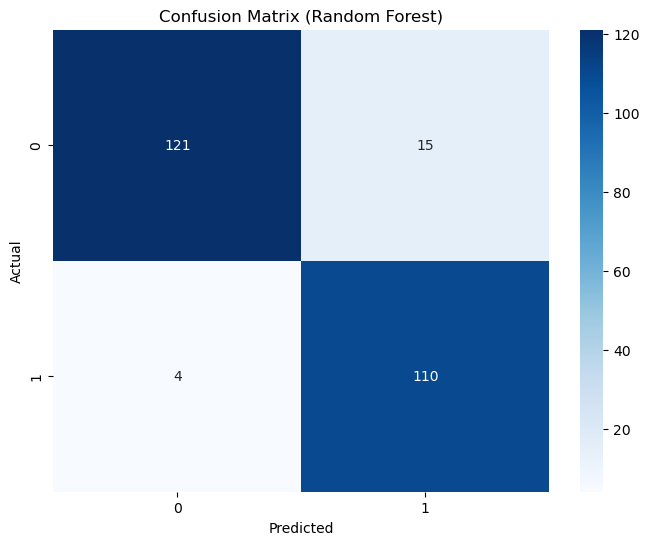

Accuracy using Random Forest: 92.40%


In [5]:
# Instantiate the Random Forest model
rf_classifier = RandomForestClassifier(random_state=0)

# Fit the model with data
rf_classifier.fit(X_train, y_train)

# # Predict the labels
y_pred_rf = rf_classifier.predict(X_test)

# Print classification report
print("Classification report for 25% of data using Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Create a confusion matrix
cnf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
# print("Confusion matrix for 25% of data using Random Forest:")
# print(cnf_matrix_rf)

# Create a heatmap for the Random Forest confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_rf, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# Calculate and print accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy using Random Forest: {acc_rf * 100:.2f}%")

Classification report for 25% of data using SVM:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       136
           1       0.90      0.94      0.92       114

    accuracy                           0.92       250
   macro avg       0.92      0.93      0.92       250
weighted avg       0.92      0.92      0.92       250



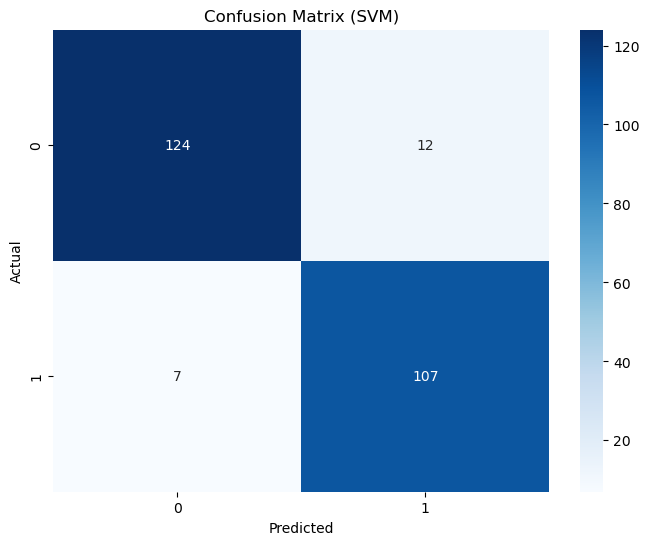

Accuracy using SVM: 92.40%


In [16]:
# Instantiate the SVM model
svm_classifier = SVC(random_state=0, kernel='sigmoid')

# Fit the model with data
svm_classifier.fit(X_train, y_train)

# Predict the labels
y_pred_svm = svm_classifier.predict(X_test)

# Print classification report
print("Classification report for 25% of data using SVM:")
print(classification_report(y_test, y_pred_svm))

# Create a confusion matrix
cnf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Create a heatmap for the SVM confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix_svm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()

# Calculate and print accuracy
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy using SVM: {acc_svm * 100:.2f}%")
